In [1]:
!pip install pyLDAvis imbalanced-learn streamlit pyngrok transformers matplotlib seaborn nltk tensorflow ipywidgets notebook jupyter

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu130

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import joblib
import warnings
import subprocess

# NLTK
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, PCA, NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans

# Imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImpbPipeline

# Deep Learning (PyTorch & Transformers)
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Conv1D, GlobalMaxPooling1D, concatenate

# Topic Modeling
import pyLDAvis
import pyLDAvis.gensim_models
import gensim
from gensim.corpora import Dictionary

# Deployment
from pyngrok import ngrok

# Configuration
%matplotlib inline
warnings.filterwarnings("ignore")

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

c:\Users\ahmed\Documents\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [4]:
column_names = ['tweet_id', 'entity', 'sentiment', 'tweet_content']

# Load data (Assuming files are in the root directory)
try:
    df_train = pd.read_csv('twitter_training.csv', names=column_names)
    df_val = pd.read_csv('twitter_validation.csv', names=column_names)
    print("Files loaded successfully.")
except FileNotFoundError:
    print("Error: Files not found. Please upload 'twitter_training.csv' and 'twitter_validation.csv'.")

print("Original Training Shape:", df_train.shape)
print("Original Validation Shape:", df_val.shape)

# Drop missing values and duplicates immediately
df_train.dropna(subset=['tweet_content'], inplace=True)
df_train.drop_duplicates(subset=['tweet_content'], inplace=True)
df_val.dropna(subset=['tweet_content'], inplace=True) # Good practice to clean val too

print(f"Training rows after cleaning: {len(df_train)}")

Files loaded successfully.
Original Training Shape: (74682, 4)
Original Validation Shape: (1000, 4)
Training rows after cleaning: 69491


In [5]:
# Initialize tools
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'): return wordnet.ADJ
    elif treebank_tag.startswith('V'): return wordnet.VERB
    elif treebank_tag.startswith('N'): return wordnet.NOUN
    elif treebank_tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

def clean_text(text):
    if pd.isna(text): return ""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#\w+', '', text)  # remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # keep only letters
    return ' '.join(text.split())

def extract_hashtags_mentions(text):
    if pd.isna(text): return [], []
    hashtags = re.findall(r"#(\w+)", text)
    mentions = re.findall(r"@(\w+)", text)
    return hashtags, mentions

def preprocess_tweet(text):
    hashtags, mentions = extract_hashtags_mentions(text)
    cleaned = clean_text(text)
    if not cleaned.strip():
        return "", hashtags, mentions

    tokens = tokenizer.tokenize(cleaned.lower())
    pos_tags = pos_tag(tokens)
    lemmatized = []
    for word, tag in pos_tags:
        if word not in stop_words and len(word) > 2:
            wn_tags = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(word, wn_tags)
            lemmatized.append(lemma)

    return ' '.join(lemmatized), hashtags, mentions

print("Preprocessing Training Set...")
processed_train = df_train['tweet_content'].apply(preprocess_tweet)
df_train['clean_text'] = processed_train.apply(lambda x: x[0])
df_train['hashtags'] = processed_train.apply(lambda x: x[1])
df_train['mentions'] = processed_train.apply(lambda x: x[2])

print("Preprocessing Validation Set...")
processed_val = df_val['tweet_content'].apply(preprocess_tweet)
df_val['clean_text'] = processed_val.apply(lambda x: x[0])

# Remove empty rows resulting from cleaning
df_train = df_train[df_train['clean_text'].str.len() > 0].reset_index(drop=True)
df_val = df_val[df_val['clean_text'].str.len() > 0].reset_index(drop=True)

print(f"Final Training Size: {len(df_train)}")

Preprocessing Training Set...
Preprocessing Validation Set...
Final Training Size: 69024


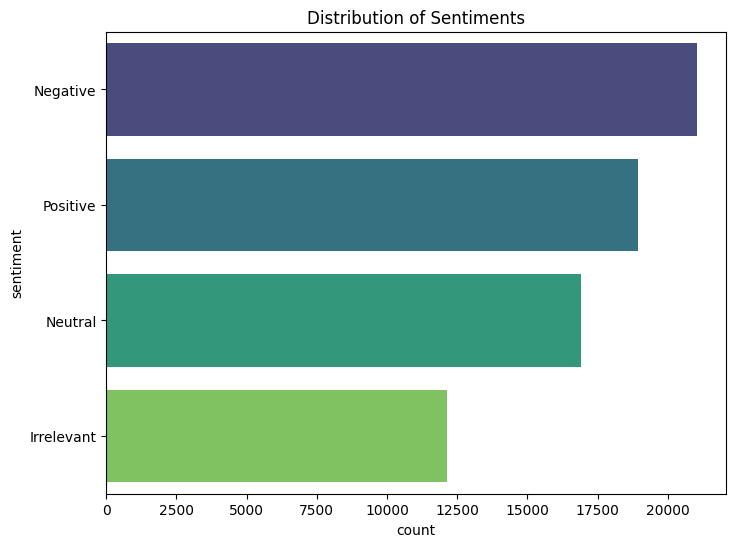

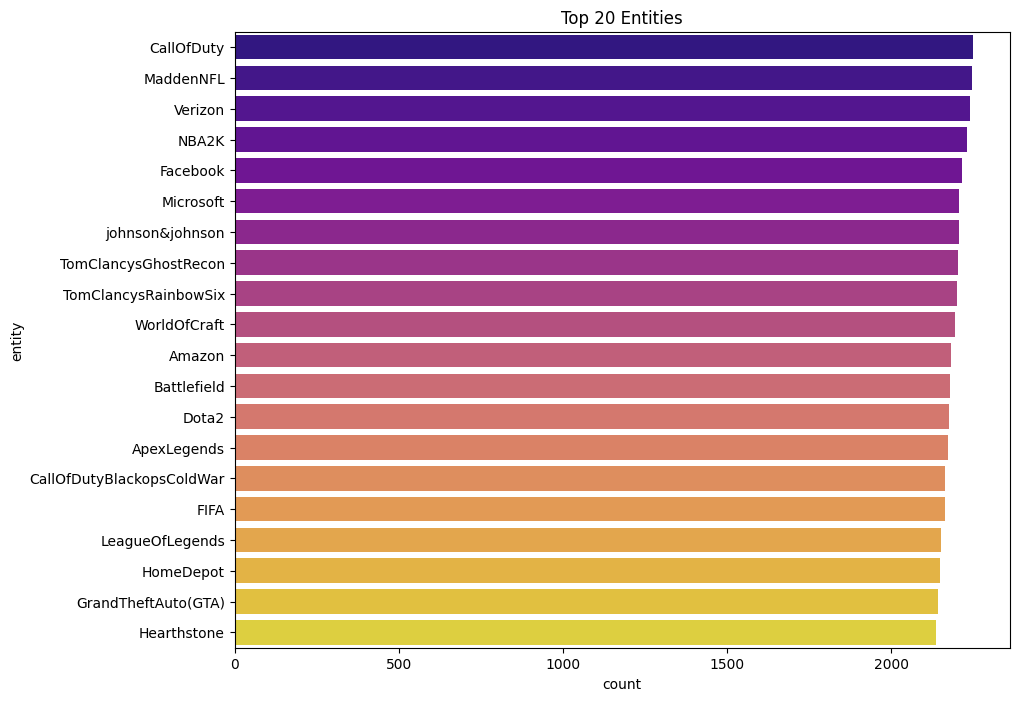

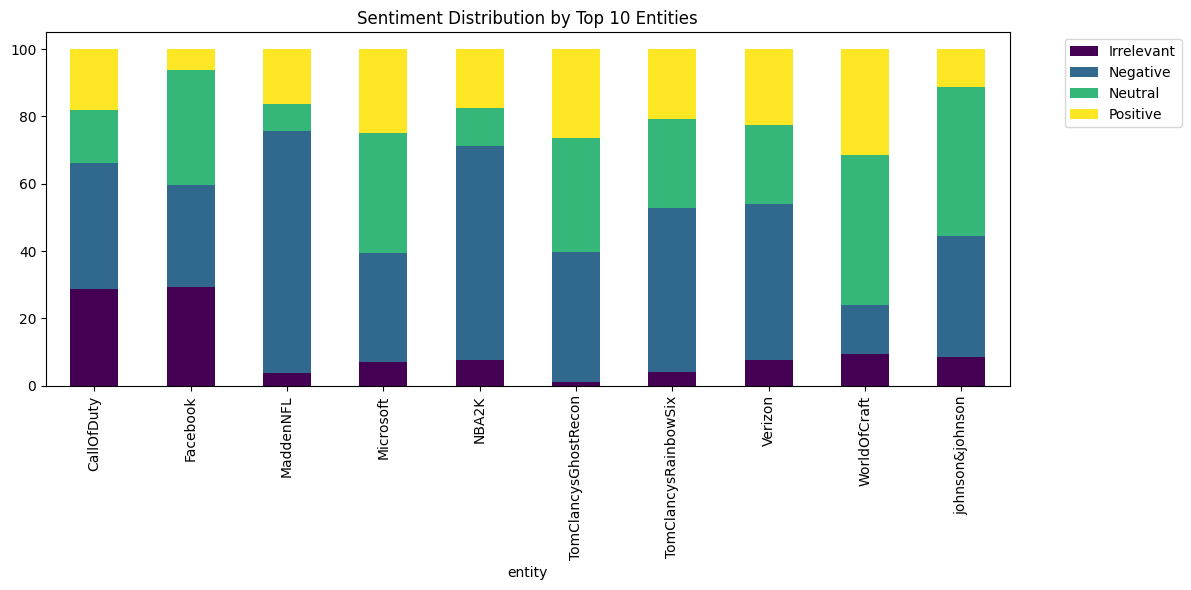

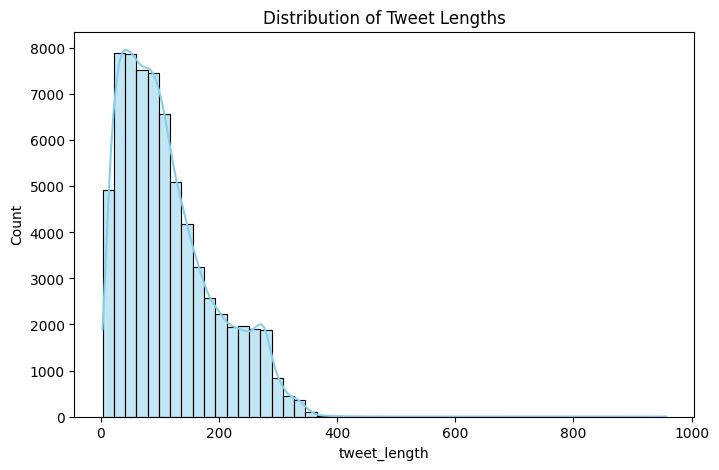

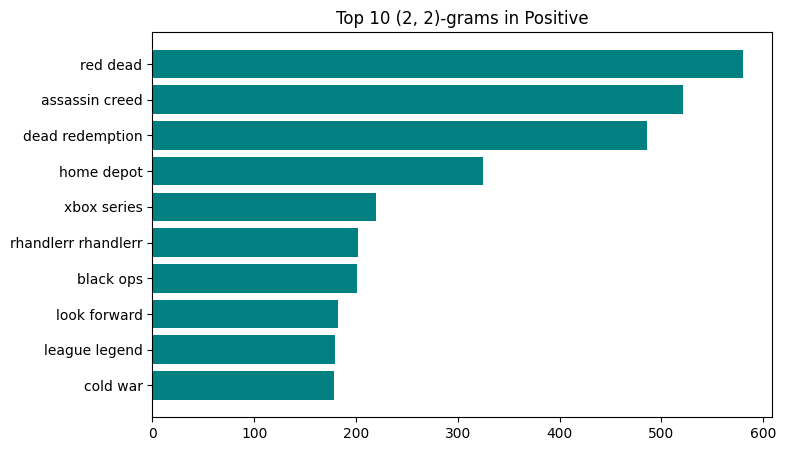

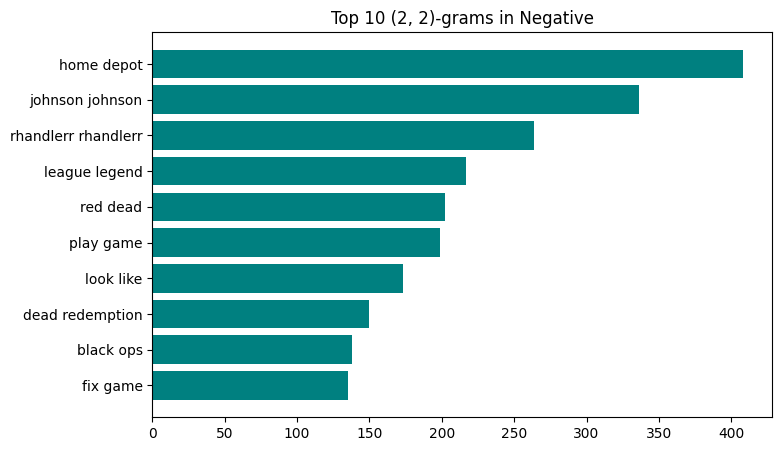

In [6]:
# 1. Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(y='sentiment', data=df_train, order=df_train['sentiment'].value_counts().index, palette='viridis')
plt.title('Distribution of Sentiments')
plt.show()

# 2. Top Entities
plt.figure(figsize=(10, 8))
top_entities = df_train['entity'].value_counts().head(20).index
sns.countplot(y='entity', data=df_train, order=top_entities, palette='plasma')
plt.title('Top 20 Entities')
plt.show()

# 3. Sentiment by Top 10 Entities
top_10_entities = df_train['entity'].value_counts().head(10).index
df_top_10 = df_train[df_train['entity'].isin(top_10_entities)]
sentiment_by_entity = pd.crosstab(df_top_10['entity'], df_top_10['sentiment'], normalize='index') * 100
sentiment_by_entity.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.title('Sentiment Distribution by Top 10 Entities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4. Tweet Length Analysis
df_train['tweet_length'] = df_train['tweet_content'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(df_train['tweet_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Tweet Lengths')
plt.show()

# 5. N-Gram Analysis
def plot_top_ngrams(sentiment_class, ngram_range=(1,1), top_k=10):
    texts = df_train[df_train['sentiment'] == sentiment_class]['clean_text']
    if texts.empty: return
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english', min_df=5, max_features=10000)
    X_counts = vec.fit_transform(texts)
    freqs = np.array(X_counts.sum(axis=0)).flatten()
    ngrams = vec.get_feature_names_out()
    top_idx = freqs.argsort()[-top_k:][::-1]
    plt.figure(figsize=(8, 5))
    plt.barh(range(len(top_idx)), freqs[top_idx], color='teal')
    plt.yticks(range(len(top_idx)), [ngrams[i] for i in top_idx])
    plt.gca().invert_yaxis()
    plt.title(f'Top {top_k} {ngram_range}-grams in {sentiment_class}')
    plt.show()

plot_top_ngrams('Positive', ngram_range=(2,2))
plot_top_ngrams('Negative', ngram_range=(2,2))

In [7]:
X_train = df_train["clean_text"]
y_train = df_train["sentiment"]
X_val = df_val['clean_text']
y_val = df_val['sentiment']

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Pipelines
pipelines = {
    'Logistic Regression': Pipeline([('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))]),
    'Random Forest': Pipeline([('clf', RandomForestClassifier(n_estimators=50, class_weight='balanced', n_jobs=-1))]),
    'SVM': Pipeline([('clf', LinearSVC(class_weight='balanced', max_iter=1000))])
}

# Cross-Validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = {}

print("Evaluating models (CV)...")
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train_tfidf, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    results[name] = scores.mean()
    print(f"{name}: {scores.mean():.4f}")

# Train Best Model
best_name = max(results, key=results.get)
best_model = pipelines[best_name]
print(f"\nTraining Best Model: {best_name}")
best_model.fit(X_train_tfidf, y_train)

# Validation
y_pred = best_model.predict(X_val_tfidf)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(classification_report(y_val, y_pred))

# Save
joblib.dump(best_model, 'best_sentiment_classifier.pkl')
print("Model saved.")

Evaluating models (CV)...
Logistic Regression: 0.7210
Random Forest: 0.8716
SVM: 0.7700

Training Best Model: Random Forest
Validation Accuracy: 0.9600
              precision    recall  f1-score   support

  Irrelevant       0.94      0.96      0.95       172
    Negative       0.96      0.97      0.96       265
     Neutral       0.99      0.93      0.96       285
    Positive       0.95      0.98      0.96       277

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999

Model saved.


Running K-Means for different k values...


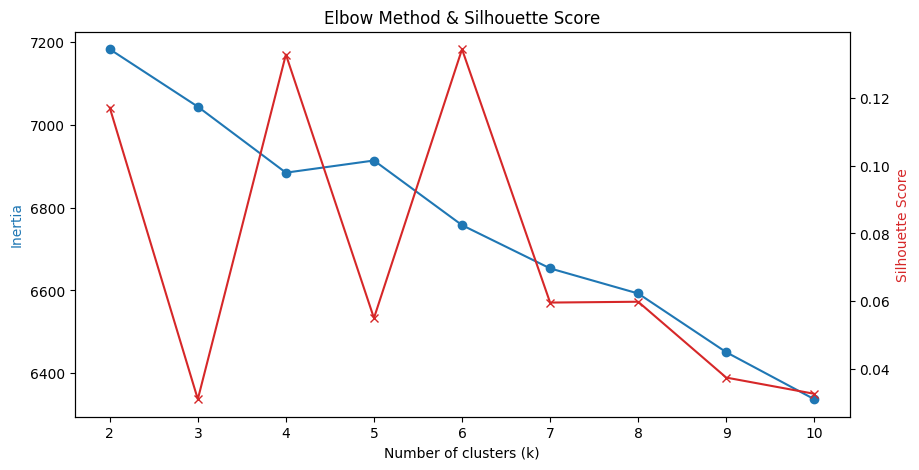

Optimal K based on Silhouette: 6


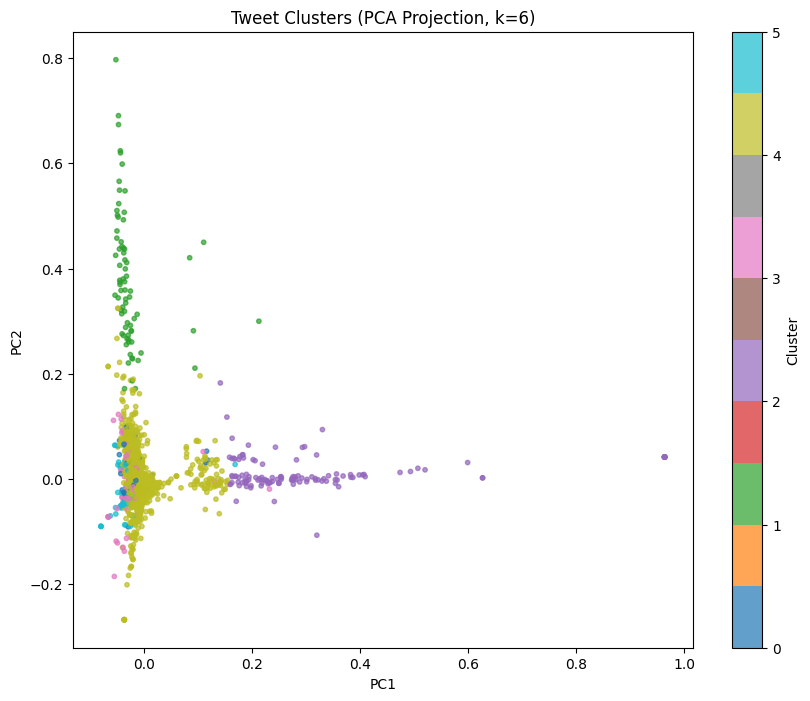


Cluster vs Sentiment Distribution:
sentiment  Negative  Positive
cluster                      
0               146       783
1               219       573
2              1084       278
3               592      1408
4             18863     14859
5               127      1026


In [8]:
# Filter for binary sentiment for unsupervised analysis
train_filtered = df_train[df_train["sentiment"].isin(["Positive", "Negative"])].copy()

# TF-IDF & SVD
vectorizer_unsup = TfidfVectorizer(max_df=0.95, min_df=3, max_features=15000, ngram_range=(1, 3), stop_words="english")
X_tfidf = vectorizer_unsup.fit_transform(train_filtered["clean_text"])
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

# Elbow Method
k_values = range(2, 11)
inertia_scores = []
sil_scores = []

print("Running K-Means for different k values...")
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_reduced)
    inertia_scores.append(km.inertia_)
    if k <= 10:
        labels = km.labels_
        sil_scores.append(silhouette_score(X_reduced, labels))

# Plot Elbow and Silhouette
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia', color='tab:blue')
ax1.plot(k_values, inertia_scores, marker='o', color='tab:blue', label='Inertia')
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:red')
ax2.plot(k_values, sil_scores, marker='x', color='tab:red', label='Silhouette')
plt.title('Elbow Method & Silhouette Score')
plt.show()

# Final Clustering
best_k = k_values[np.argmax(sil_scores)]
print(f"Optimal K based on Silhouette: {best_k}")
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=30)
clusters = kmeans_final.fit_predict(X_reduced)
train_filtered['cluster'] = clusters

# PCA Visualization
pca = PCA(n_components=2, random_state=42)
sample_idx = np.random.choice(X_reduced.shape[0], min(4000, X_reduced.shape[0]), replace=False)
X_pca = pca.fit_transform(X_reduced[sample_idx])
labels_sample = clusters[sample_idx]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_sample, cmap='tab10', s=10, alpha=0.7)
plt.title(f'Tweet Clusters (PCA Projection, k={best_k})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Cluster')
plt.show()

print("\nCluster vs Sentiment Distribution:")
print(pd.crosstab(train_filtered['cluster'], train_filtered['sentiment']))

In [9]:
# NMF
n_topics = 10
nmf_model = NMF(n_components=n_topics, random_state=42, init="nndsvd")
W_nmf = nmf_model.fit_transform(X_tfidf)
feature_names = np.array(vectorizer_unsup.get_feature_names_out())
print("--- NMF Topics ---")
for topic_idx, topic in enumerate(nmf_model.components_):
    top_indices = topic.argsort()[::-1][:10]
    print(f"Topic {topic_idx}: {', '.join(feature_names[top_indices])}")

# Sklearn LDA
count_vec = CountVectorizer(max_df=0.95, min_df=5, max_features=10000, stop_words='english')
X_count = count_vec.fit_transform(train_filtered["clean_text"])
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method="batch")
lda_model.fit(X_count)
print("\n--- Sklearn LDA Topics ---")
terms = count_vec.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    top_indices = topic.argsort()[::-1][:10]
    print(f"Topic {topic_idx}: {', '.join(terms[top_indices])}")

# Gensim LDA & Visualization
tokenized_docs = [doc.split() for doc in train_filtered["clean_text"]]
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

n_topics_new = 15
gensim_lda_new = gensim.models.LdaModel(
    corpus=corpus, id2word=dictionary, num_topics=n_topics_new, random_state=42, passes=5
)
print(f"Retrained Gensim LDA model with {n_topics_new} topics.")

# Save Gensim Models
joblib.dump(gensim_lda_new, 'gensim_lda_model.pkl')
joblib.dump(dictionary, 'gensim_dictionary.pkl')
print("Gensim LDA model and dictionary saved.")

# Visualize
pyLDAvis.enable_notebook()
vis_new = pyLDAvis.gensim_models.prepare(gensim_lda_new, corpus, dictionary)
vis_new

--- NMF Topics ---
Topic 0: play, like, really, time, look, bad, new, fun, make, dont
Topic 1: fuck, fuck fuck, let fuck, let, fucking, dont fuck, fuck game, fuck shit, holy fuck, yall
Topic 2: love, love game, love new, new, love play, really love, warcraft, love love, creed, love pubg
Topic 3: dead, red, red dead, redemption, dead redemption, red dead redemption, play red, play red dead, masterpiece, finish
Topic 4: shit, holy, holy shit, gta, fix, wtf, dog, fuck shit, hate, dog shit
Topic 5: good, look, good game, look good, feel good, news, good news, really good, feel, wow
Topic 6: home, depot, home depot, thank, work, happy, miss, unk, lowes, walmart
Topic 7: rhandlerr, rhandlerr rhandlerr, rhandlerr rhandlerr rhandlerr, nice, thank, wtf, fix, thanks, ban, nice rhandlerr
Topic 8: game, best, fix, wtf, best game, play game, video, server, video game, year
Topic 9: wait, xbox, wait play, come, series, wait game, xbox series, amazing, creed, assassin

--- Sklearn LDA Topics ---
Topi

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6     -0.161549  0.117651       1        1  8.678143
0     -0.138595  0.010678       2        1  8.557653
3     -0.123732 -0.107299       3        1  8.299240
11    -0.170041 -0.003976       4        1  8.291578
10    -0.072831 -0.148236       5        1  7.996038
12    -0.186635  0.028621       6        1  7.388218
7      0.016008  0.262846       7        1  6.751234
5      0.002691 -0.189249       8        1  6.697783
4      0.068329 -0.020679       9        1  6.396961
13     0.074986  0.115022      10        1  5.826943
9      0.149041  0.061530      11        1  5.782030
1      0.008533  0.103147      12        1  5.568424
14     0.083710 -0.188702      13        1  5.320117
2      0.192892 -0.101864      14        1  4.525598
8      0.257193  0.060512      15        1  3.920041, topic_info=            Term         Freq        Total Category  logprob  loglift
847      johnson  3376.000000  3376.000000  Default  30.0000  30.0000
56          fuck  2861.000000  2861.000000  Default  29.0000  29.0000
166         play  4955.000000  4955.000000  Default  28.0000  28.0000
276         love  2632.000000  2632.000000  Default  27.0000  27.0000
39          good  3358.000000  3358.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
500        power   219.575105   330.213622  Topic15  -4.2799   2.8310
939      without   266.960208   527.587121  Topic15  -4.0845   2.5579
631   absolutely   254.497363   525.137872  Topic15  -4.1323   2.5147
1227    honestly   155.089924   207.800711  Topic15  -4.6276   2.9465
152           go   257.504467  2342.224680  Topic15  -4.1206   1.0312

[722 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1702      2  0.995180        able
811       4  0.994211    absolute
631       7  0.213277  absolutely
631      10  0.300873  absolutely
631      15  0.483683  absolutely
...     ...       ...         ...
1139      4  0.995083   yesterday
442       2  0.308913       youre
442       7  0.689967       youre
827       7  0.990607       youtu
676       7  0.997648     youtube

[1103 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 4, 12, 11, 13, 8, 6, 5, 14, 10, 2, 15, 3, 9])

In [10]:
# Mappings
sentiment_to_int = {'Positive': 0, 'Negative': 1, 'Neutral': 2, 'Irrelevant': 3}
df_train['sentiment_label'] = df_train['sentiment'].map(sentiment_to_int)
df_val['sentiment_label'] = df_val['sentiment'].map(sentiment_to_int)

# Tokenization
tokenizer_bert = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
encodings_train = tokenizer_bert(list(df_train['clean_text'].values), truncation=True, padding='max_length', return_tensors='pt', max_length=128)
encodings_val = tokenizer_bert(list(df_val['clean_text'].values), truncation=True, padding='max_length', return_tensors='pt', max_length=128)

# Dataset
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(encodings_train, df_train['sentiment_label'].tolist())
val_dataset = SentimentDataset(encodings_val, df_val['sentiment_label'].tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Model
num_labels = len(sentiment_to_int)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training Loop
epochs = 3
print(f"Training on {device}...")
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {total_loss/len(train_loader):.4f}")

print(model)

# Save
torch.save(model.state_dict(), 'distilbert_sentiment_classifier.pt')
print("Fine-tuned DistilBERT model saved.")

# Evaluation
model.eval()
val_true_labels, val_predictions = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        val_true_labels.extend(labels.cpu().numpy())
        val_predictions.extend(predictions.cpu().numpy())

int_to_sentiment = {v: k for k, v in sentiment_to_int.items()}
predicted_sentiment_names = [int_to_sentiment[p] for p in val_predictions]
true_sentiment_names = [int_to_sentiment[t] for t in val_true_labels]
print("\nDistilBERT Classification Report:")
print(classification_report(true_sentiment_names, predicted_sentiment_names))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on cuda...
Epoch 1/3, Average Loss: 0.8118
Epoch 2/3, Average Loss: 0.2970
Epoch 3/3, Average Loss: 0.1520
DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((76

In [11]:
# Keras Tokenizer
max_words = 10000
tokenizer_lstm = Tokenizer(num_words=max_words, oov_token='<unk>')
tokenizer_lstm.fit_on_texts(df_train['clean_text'])
X_train_seq = tokenizer_lstm.texts_to_sequences(df_train['clean_text'])
X_val_seq = tokenizer_lstm.texts_to_sequences(df_val['clean_text'])
max_len = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

# 1. LSTM Model
model_lstm = Sequential([
    Embedding(len(tokenizer_lstm.word_index)+1, 128, input_length=max_len),
    LSTM(128),
    Dense(num_labels, activation='softmax')
])
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Training LSTM...")
model_lstm.fit(X_train_pad, df_train['sentiment_label'], epochs=5, batch_size=32, validation_data=(X_val_pad, df_val['sentiment_label']))

print("\n--- LSTM Model Summary ---")
model_lstm.summary()

# 2. CNN Model
input_layer = Input(shape=(max_len,))
embed = Embedding(len(tokenizer_lstm.word_index)+1, 128, input_length=max_len)(input_layer)
conv_blocks = [GlobalMaxPooling1D()(Conv1D(128, k, activation='relu')(embed)) for k in [3,4,5]]
merged = concatenate(conv_blocks)
dense = Dense(128, activation='relu')(merged)
output = Dense(num_labels, activation='softmax')(dense)
model_cnn = Model(inputs=input_layer, outputs=output)
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("\nTraining CNN...")
model_cnn.fit(X_train_pad, df_train['sentiment_label'], epochs=5, batch_size=32, validation_data=(X_val_pad, df_val['sentiment_label']))

# ... after model_cnn.compile(...)
print("\n--- CNN Model Summary ---")
model_cnn.summary()

Training LSTM...
Epoch 1/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 105s 48ms/step - accuracy: 0.6600 - loss: 0.8535 - val_accuracy: 0.8699 - val_loss: 0.4290
Epoch 2/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 102s 47ms/step - accuracy: 0.8228 - loss: 0.4776 - val_accuracy: 0.9059 - val_loss: 0.3108
Epoch 3/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 102s 47ms/step - accuracy: 0.8741 - loss: 0.3428 - val_accuracy: 0.9259 - val_loss: 0.2602
Epoch 4/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 122s 56ms/step - accuracy: 0.9041 - loss: 0.2619 - val_accuracy: 0.9369 - val_loss: 0.2460
Epoch 5/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 157s 73ms/step - accuracy: 0.9255 - loss: 0.2045 - val_accuracy: 0.9489 - val_loss: 0.2153

--- LSTM Model Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 129, 128)         │     4,251,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (32, 128)              │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 4)                │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,149,710 (50.16 MB)

 Trainable params: 4,383,236 (16.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,766,474 (33.44 MB)


Training CNN...
Epoch 1/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.7043 - loss: 0.7540 - val_accuracy: 0.9289 - val_loss: 0.2261
Epoch 2/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9096 - loss: 0.2553 - val_accuracy: 0.9630 - val_loss: 0.1510
Epoch 3/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9528 - loss: 0.1307 - val_accuracy: 0.9560 - val_loss: 0.1764
Epoch 4/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.9637 - loss: 0.0999 - val_accuracy: 0.9540 - val_loss: 0.1970
Epoch 5/5
2157/2157 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - accuracy: 0.9691 - loss: 0.0838 - val_accuracy: 0.9640 - val_loss: 0.1701

--- CNN Model Summary ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 129)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 129, 128)  │  4,251,136 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 127, 128)  │     49,280 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 126, 128)  │     65,664 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 125, 128)  │     82,048 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     49,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        516 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,493,774 (51.47 MB)

 Trainable params: 4,497,924 (17.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,995,850 (34.32 MB)